In [2]:
%matplotlib notebook
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import approximation
import matplotlib.pyplot as plt
import json, time, datetime, math
import operator
from itertools import count

now = datetime.datetime.now()
ROOT_PATH = 'data/'
DATA_PATH = '-'.join(str(x) for x in [(now.year), now.month, now.day])
LOAD_DATA_PATH = '2018-2-6'

def sorted_map(map):
    ms = sorted(map.items(), key=operator.itemgetter(1), reverse=True)
    return ms

def sorted_df(cen):
    return pd.DataFrame(sorted(cen.items(), key=operator.itemgetter(1), reverse=True))

def print_progress(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, errors = 0, fill = '+'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s - errors: %s' % (prefix, bar, percent, suffix, errors), end = '\r')
    # Print New Line on Complete
    if iteration == (total - 2): 
        print()
        
def trim_top(g, top_from, n=20):
    g2 = g.copy()
    pick_list = top_from[0:n][0].tolist()
    for n in g.nodes():
        if n not in pick_list:
            g2.remove_node(n)
        #break
    return g2

def trim_degrees(g, degree=1):
    g2 = g.copy()
    d = nx.degree(g2)
    for n in g.nodes():
        if d[n]<=degree:
            g2.remove_node(n)
    return g2

def draw_graph(core1, core2, title, options=None, core2_node_color='red'):
    print(len(core1), len(core2))
    if options == None:
        options = {
            'node_color': 'black',
            'node_size': 4,
            'width': 0.05,
            'font_size': 8
        }

    pos1 = nx.spring_layout(core1)
    pos2 = nx.spring_layout(core2)

    fig1 = plt.figure(figsize=(9,9))
    ax1 = fig1.add_subplot(111)
    nx.draw_networkx(core1, pos1, with_labels=False, font_color='black', alpha=0.07, **options)
    nx.draw_networkx(core2, pos2, with_labels=True, font_color=core2_node_color, **options)
    plt.title(title)
    plt.axis('off')
    ax1.plot()


In [3]:
submissions = pd.read_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'submissions.pkl').query('subreddit!="garlicoin"')
comments = pd.read_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'comments.pkl').query('subreddit!="garlicoin"')
comments[['parent_type','parent_id']] = comments['parent_id'].str.split('_',expand=True)

In [4]:
comments = comments.query('author != "[deleted]"').reset_index(drop=True)

# Type of graph, nodes and edges
* Nodes are authors of the submissions and comments.
* Edges are interactions between authors, such as comments on the submission or direct reply to the comment of other author.
* Since the interactions are directed and we can have multiple edges between same users as well as two types of edges, graph type is Multi Direct Graph.

In [5]:
authors_1 = pd.DataFrame({
    'author': submissions['author']
})

authors_2 = pd.DataFrame({
    'author': comments['author']
}) 

authors = pd.concat([authors_1, authors_2]).drop_duplicates().reset_index(drop=True)
authors.info()

print('num_comments:', comments.query('parent_type=="t1"')['parent_type'].count())
print('num_links:', comments.query('parent_type=="t3"')['parent_type'].count())
print('total:', comments['id'].count())

#625480

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242121 entries, 0 to 242120
Data columns (total 1 columns):
author    242121 non-null object
dtypes: object(1)
memory usage: 1.8+ MB
num_comments: 1172934
num_links: 540112
total: 1713046


In [6]:
edges_sub = pd.merge(
    comments[comments['parent_type'] == 't3'].reset_index(),
    submissions, 
    left_on='parent_id', 
    right_on='id', 
    how='left', 
    suffixes=('_left', '_right')
)
edges_sub = edges_sub.query('author_left != "[deleted]" & author_right != "[deleted]"').reset_index(drop=True)
edges_sub = edges_sub.query('author_left != author_right').reset_index(drop=True)
edge_fields_sub = ['author_left', 'author_right', 'score_left', 'id_left', 'id_right', 'subreddit_left']
edges_sub = edges_sub[edge_fields_sub]
edges_sub['weight'] = edges_sub['score_left']
edges_sub['type'] = 'com_on_sub'
edges_sub = edges_sub.rename(columns={'subreddit_left': 'subreddit'})
edges_sub.columns

Index(['author_left', 'author_right', 'score_left', 'id_left', 'id_right',
       'subreddit', 'weight', 'type'],
      dtype='object')

In [7]:
edges_com = pd.merge(
    comments[comments['parent_type'] == 't1'].reset_index(), 
    comments, 
    left_on='parent_id', 
    right_on='id', 
    how='left', 
    suffixes=('_left', '_right')
)

edge_fields = ['author_left', 'author_right', 'score_left', 'id_left', 'id_right', 'subreddit_left']
edges_com = edges_com[edge_fields]
edges_com['weight'] = edges_com['score_left']
edges_com['type'] = 'com_on_com'
edges_com = edges_com.rename(columns={'subreddit_left': 'subreddit'})
edges_com.columns

Index(['author_left', 'author_right', 'score_left', 'id_left', 'id_right',
       'subreddit', 'weight', 'type'],
      dtype='object')

In [8]:
#edges_com = edges_com[0:10][['author_left', 'author_right']]
#print(edges_sub[0:5][['author_left', 'author_right']])

#print(edges_com[0:5][['author_left', 'author_right']])
#print(edges_com[['author_left', 'author_right']].query('author_right'))
print(edges_sub.columns)
print()
print(edges_com.columns)
#print(comments.sort_values(by='score', ascending=False)[-50:-1]['score'])

#comments.subreddit.unique()

Index(['author_left', 'author_right', 'score_left', 'id_left', 'id_right',
       'subreddit', 'weight', 'type'],
      dtype='object')

Index(['author_left', 'author_right', 'score_left', 'id_left', 'id_right',
       'subreddit', 'weight', 'type'],
      dtype='object')


In [9]:
g = nx.from_pandas_dataframe(
    pd.concat([edges_sub, edges_com], ignore_index=True), 
    'author_left', 
    'author_right', 
    ['weight', 'score_left', 'id_left', 'id_right', 'subreddit', 'type'], 
    create_using=nx.MultiDiGraph()
)


# Graph Metrics

In [10]:
print(nx.info(g))
print('Graph density:', nx.density(g))
print('Self loop:', nx.number_of_selfloops(g))
print('Is strongly connected?', nx.is_strongly_connected(g))
print('Number of strongly connected components:', nx.number_strongly_connected_components(g))
print('Number of weakly connected components:', nx.number_weakly_connected_components(g))

Name: 
Type: MultiDiGraph
Number of nodes: 226406
Number of edges: 1691975
Average in degree:   7.4732
Average out degree:   7.4732
Graph density: 3.300805970033885e-05
Self loop: 7370
Is strongly connected? False
Number of strongly connected components: 92402
Number of weakly connected components: 3


# Top 20 influencers by Degree centrality
### Koliko drugih ljudi data osoba može direktno kontaktirati?

In [11]:
top_num = 20
deg_cen = sorted_df(nx.degree_centrality(g))
print(50*'-')
print(deg_cen[0:top_num])

--------------------------------------------------
                       0         1
0          AutoModerator  0.032212
1                    NaN  0.029991
2                   mvea  0.025552
3                  tippr  0.024500
4                  b1tcc  0.022305
5            rBitcoinMod  0.020583
6                Z_staff  0.019333
7             mungojelly  0.016559
8                  fabwa  0.015344
9   DestroyerOfShitcoins  0.014956
10              jessquit  0.012111
11              rdar1999  0.010724
12                 --orb  0.010349
13              coin2k17  0.010252
14            KnifeOfPi2  0.010243
15         unitedstatian  0.010234
16              perogies  0.009761
17              Fulvio55  0.009359
18                speckz  0.009112
19   censorship_notifier  0.008525


# Top 20 influencers by PageRank algorithm
### 

In [13]:
page_rank = sorted_df(nx.pagerank_scipy(g, alpha=0.8))
print(page_rank[0:top_num])

                  0         1
0              mvea  0.005083
1           Z_staff  0.004514
2       rBitcoinMod  0.001914
3            Amidza  0.001843
4               NaN  0.001731
5            speckz  0.001653
6             b1tcc  0.001477
7             fabwa  0.001289
8   HudsonRiverLine  0.000927
9        AdamCannon  0.000924
10   pixel-gamer-3D  0.000899
11   MichaelRahmani  0.000846
12        BluntLord  0.000833
13            tag65  0.000826
14      maxwellhill  0.000801
15    Gabriel-Lewis  0.000749
16     delumstudios  0.000747
17  Elementz_Reborn  0.000707
18        lriccardo  0.000665
19        iAmTheTot  0.000664


# Top 20 influencers by Betweenness centrality
### Koliko je verovatno da će data osoba imati ulogu posrednika između nekih drugih dvoje ljudi iz mreže?

In [14]:
if False:
    betweenness_cen = sorted_df(nx.betweenness_centrality(g, k=256, weight='weight'))
    #betweenness_cen.to_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'betweenness_large.pkl')
else:
    betweenness_cen = pd.read_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'betweenness_large.pkl')

print(50*'-')
print(betweenness_cen[0:top_num])

--------------------------------------------------
                       0         1
0          AutoModerator  0.024189
1   DestroyerOfShitcoins  0.011032
2               Aceionic  0.009475
3                kushari  0.009022
4   Get_Back_To_Work_Now  0.008530
5                Z_staff  0.007485
6              lriccardo  0.007026
7            Win10isLord  0.006892
8            RemindMeBot  0.006390
9              nesnalica  0.006034
10           WikiTextBot  0.006027
11            Combatical  0.005797
12                Amidza  0.005676
13         unitedstatian  0.005174
14  Reacher-Said-Nothing  0.004982
15           Tharsis-evo  0.004928
16           TiltMastery  0.004927
17      CattusKittekatus  0.004836
18            KnifeOfPi2  0.004786
19          Chumbag_love  0.004746


<IPython.core.display.Javascript object>


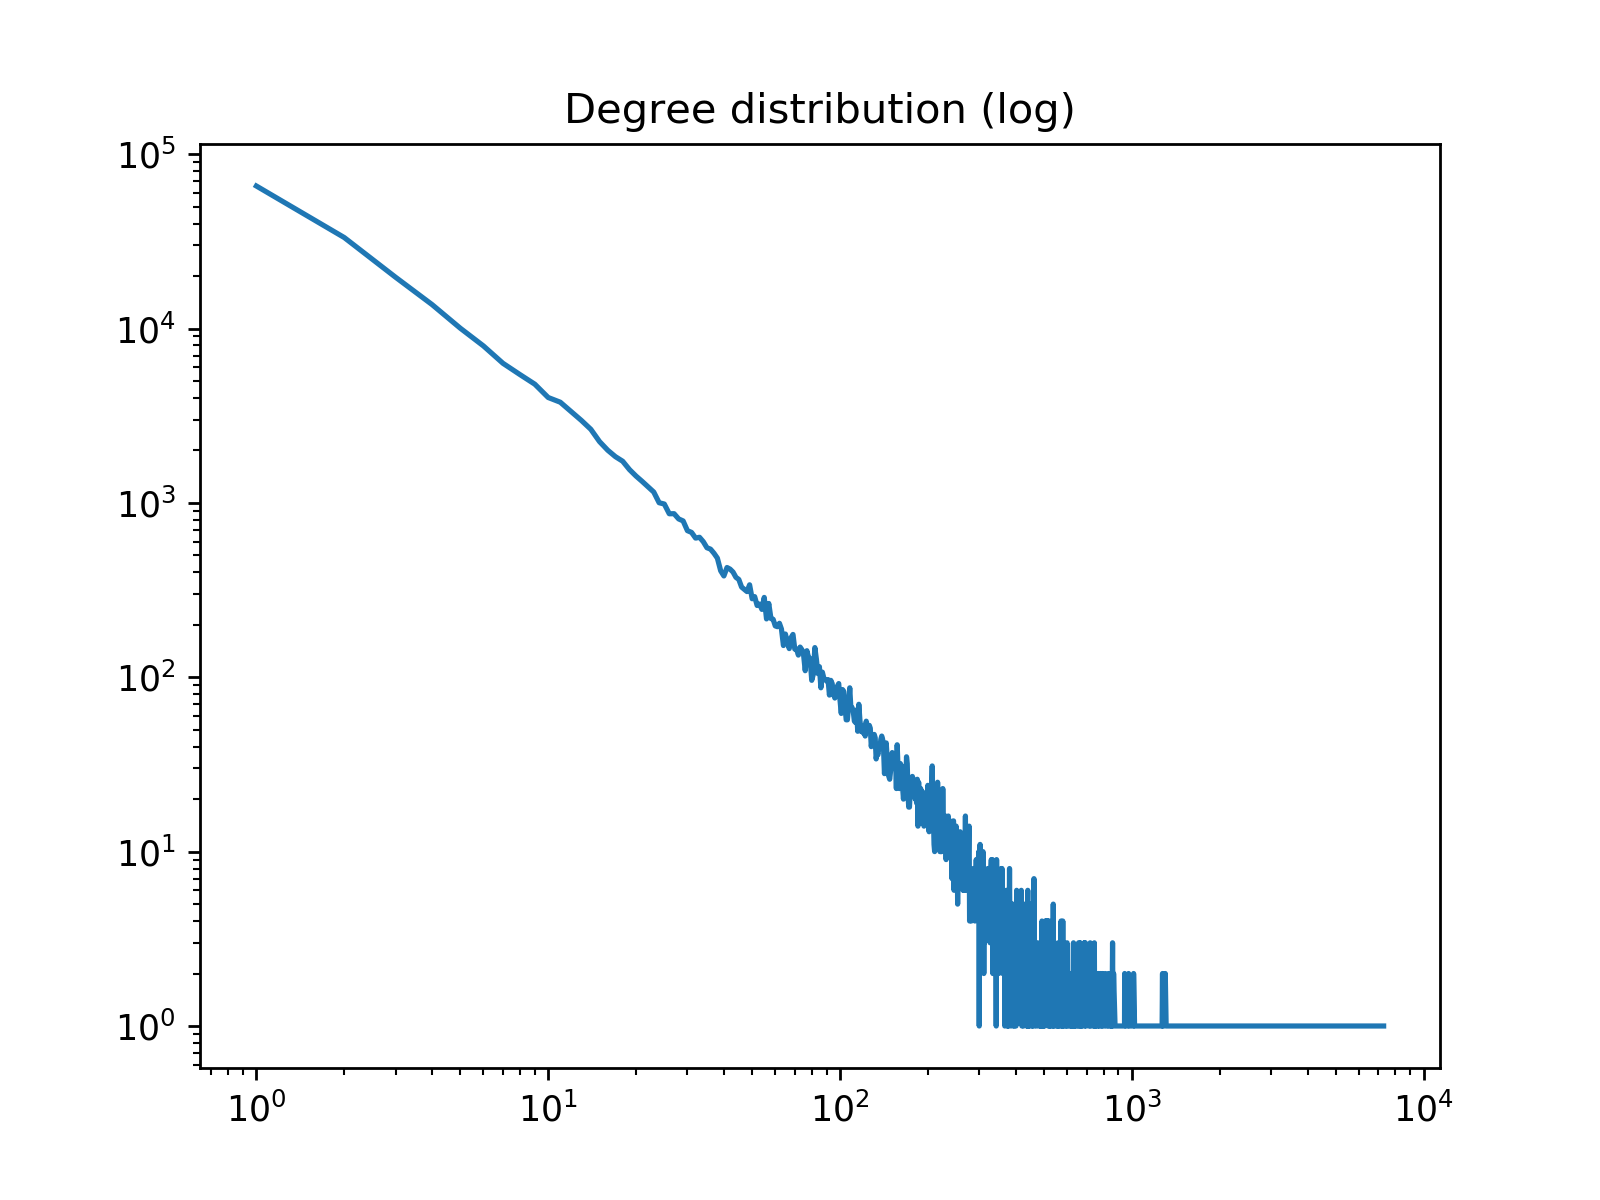

In [26]:
def plot_degree_distribution(graph):
    degs = {}
    for n in graph.nodes():
        deg = graph.degree(n)
        if deg not in degs :
            degs [deg] = 0
        degs [deg] += 1
    items = sorted(degs.items())
    fig = plt.figure ()
    ax = fig.add_subplot (111)
    ax.plot([ k for (k, v) in items], [ v for (k, v) in items ])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Degree distribution (log)')
    
plot_degree_distribution(g)

1200 20


<IPython.core.display.Javascript object>


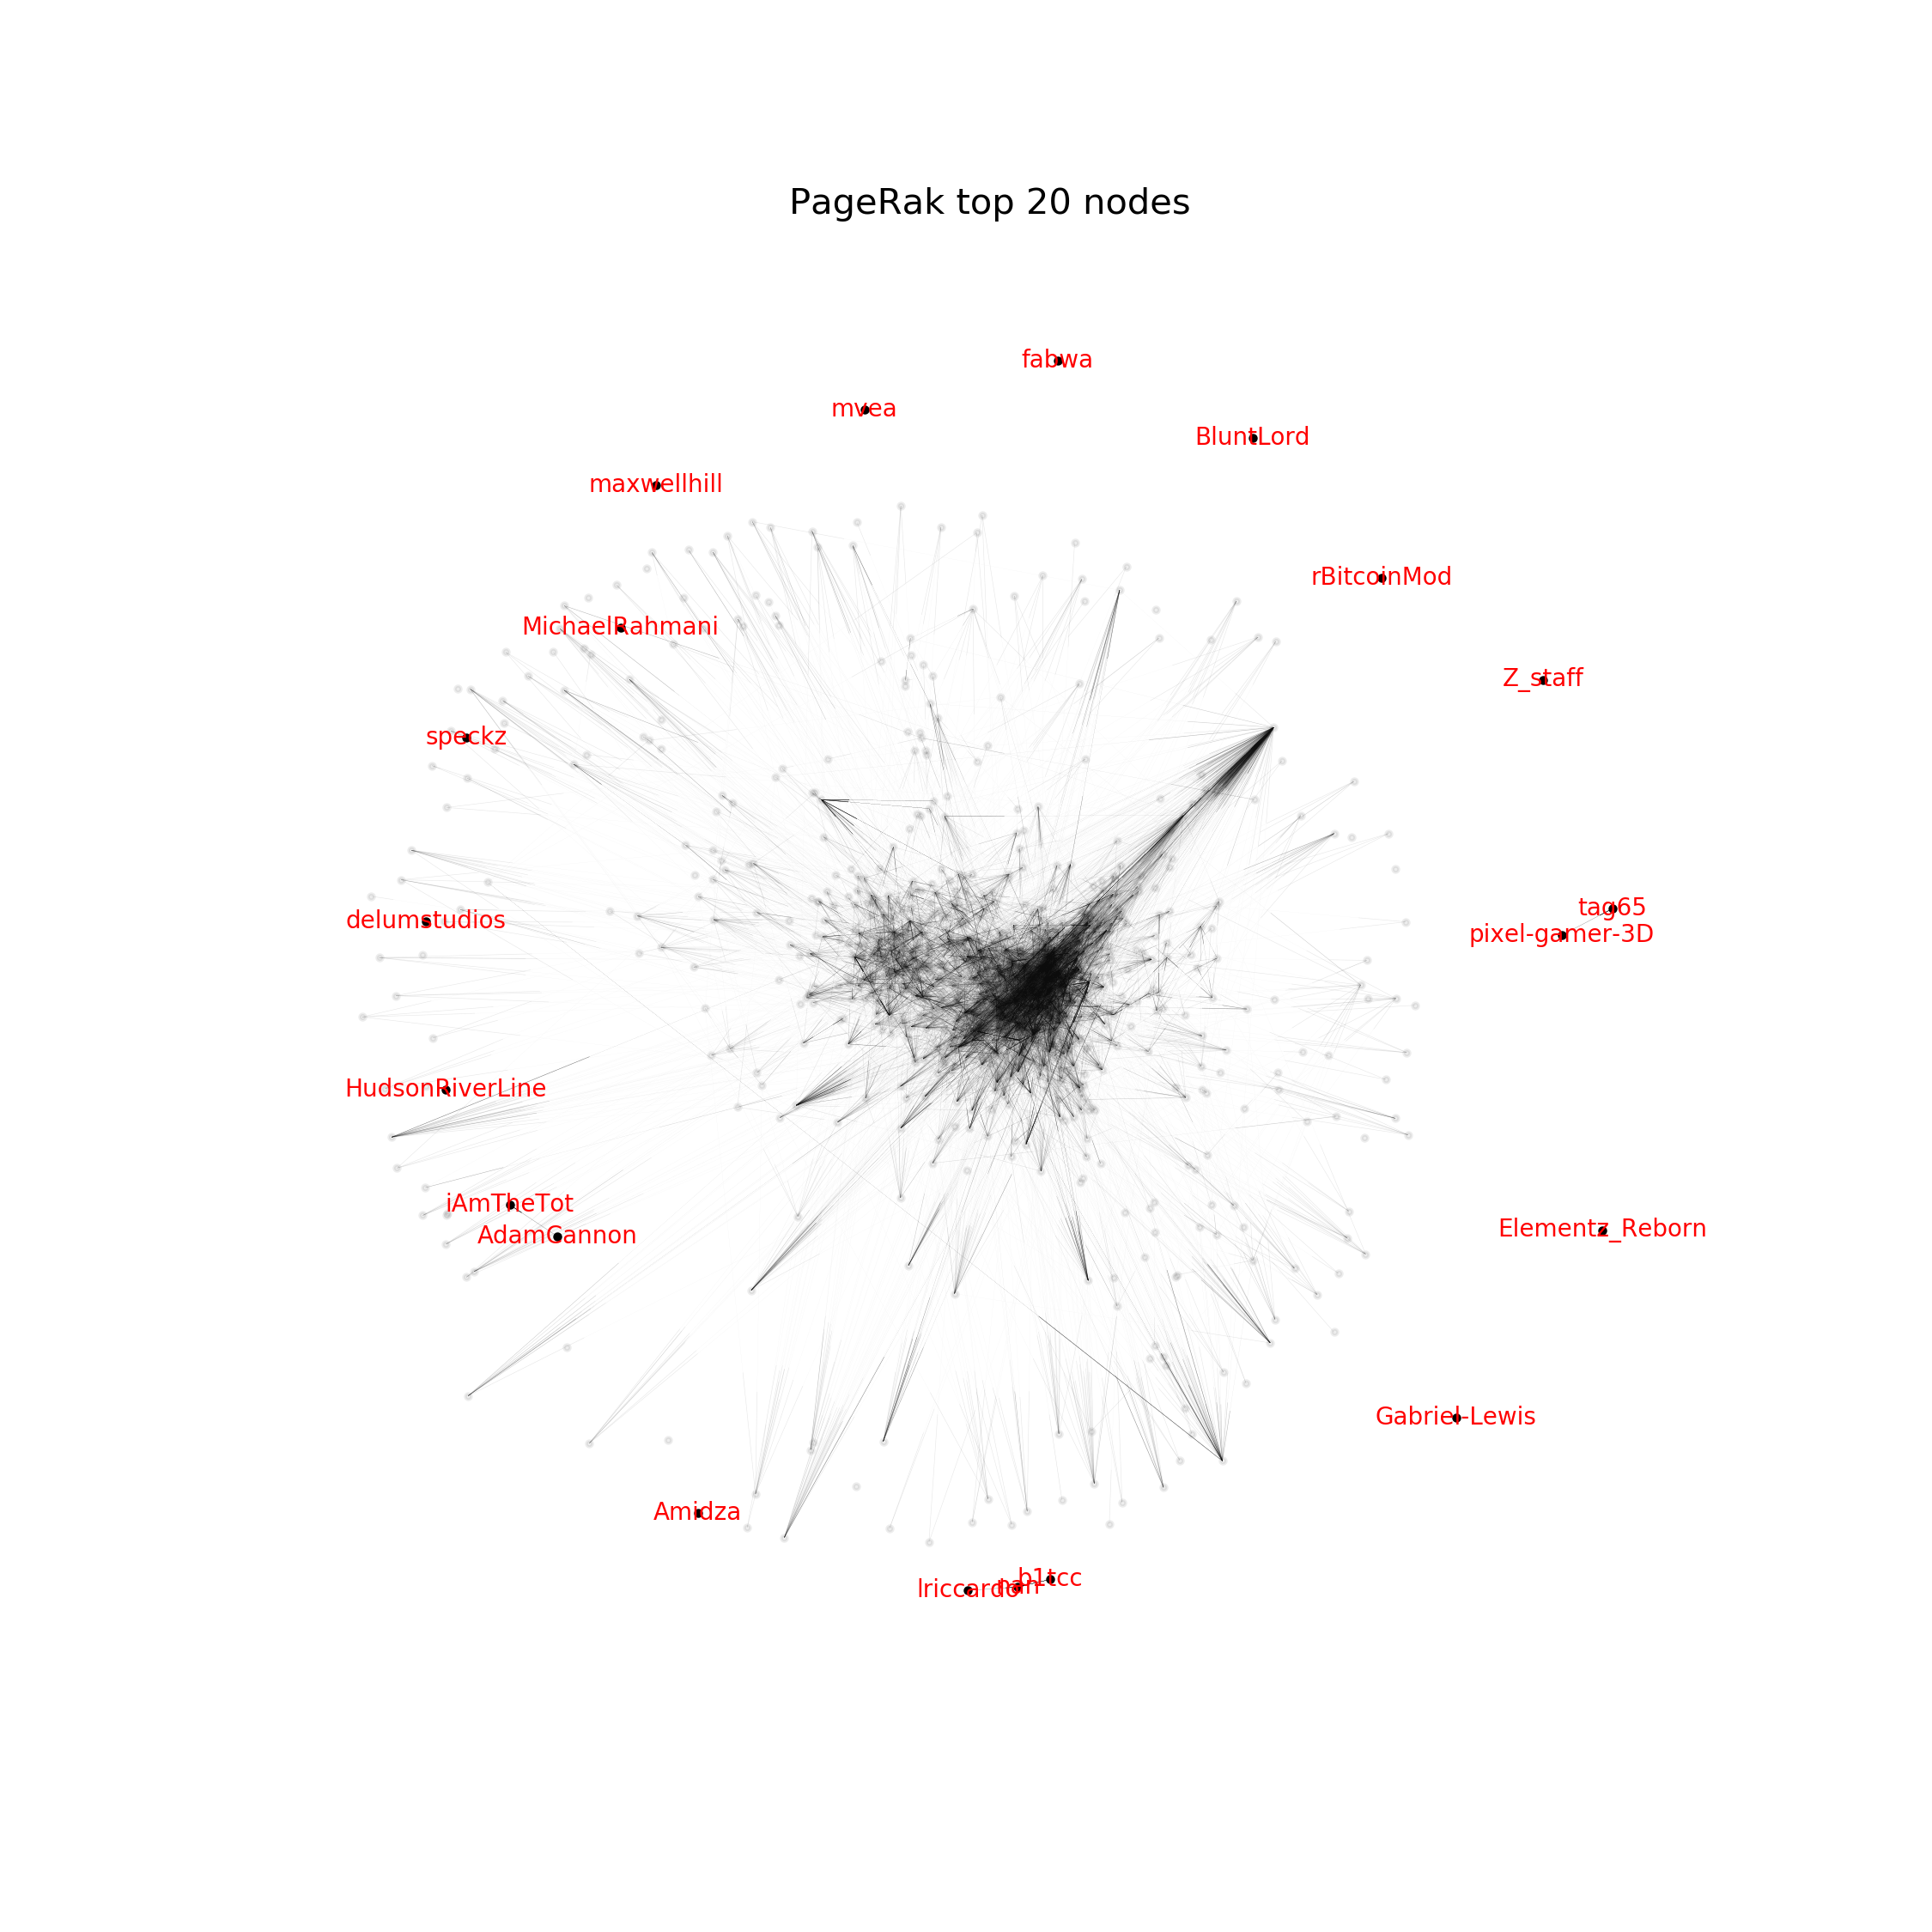

In [15]:
core1 = trim_top(g, page_rank, n=1200)
core2 = trim_top(g, page_rank, n=20)
draw_graph(core1, core2, 'PageRak top 20 nodes')

1200 20


<IPython.core.display.Javascript object>


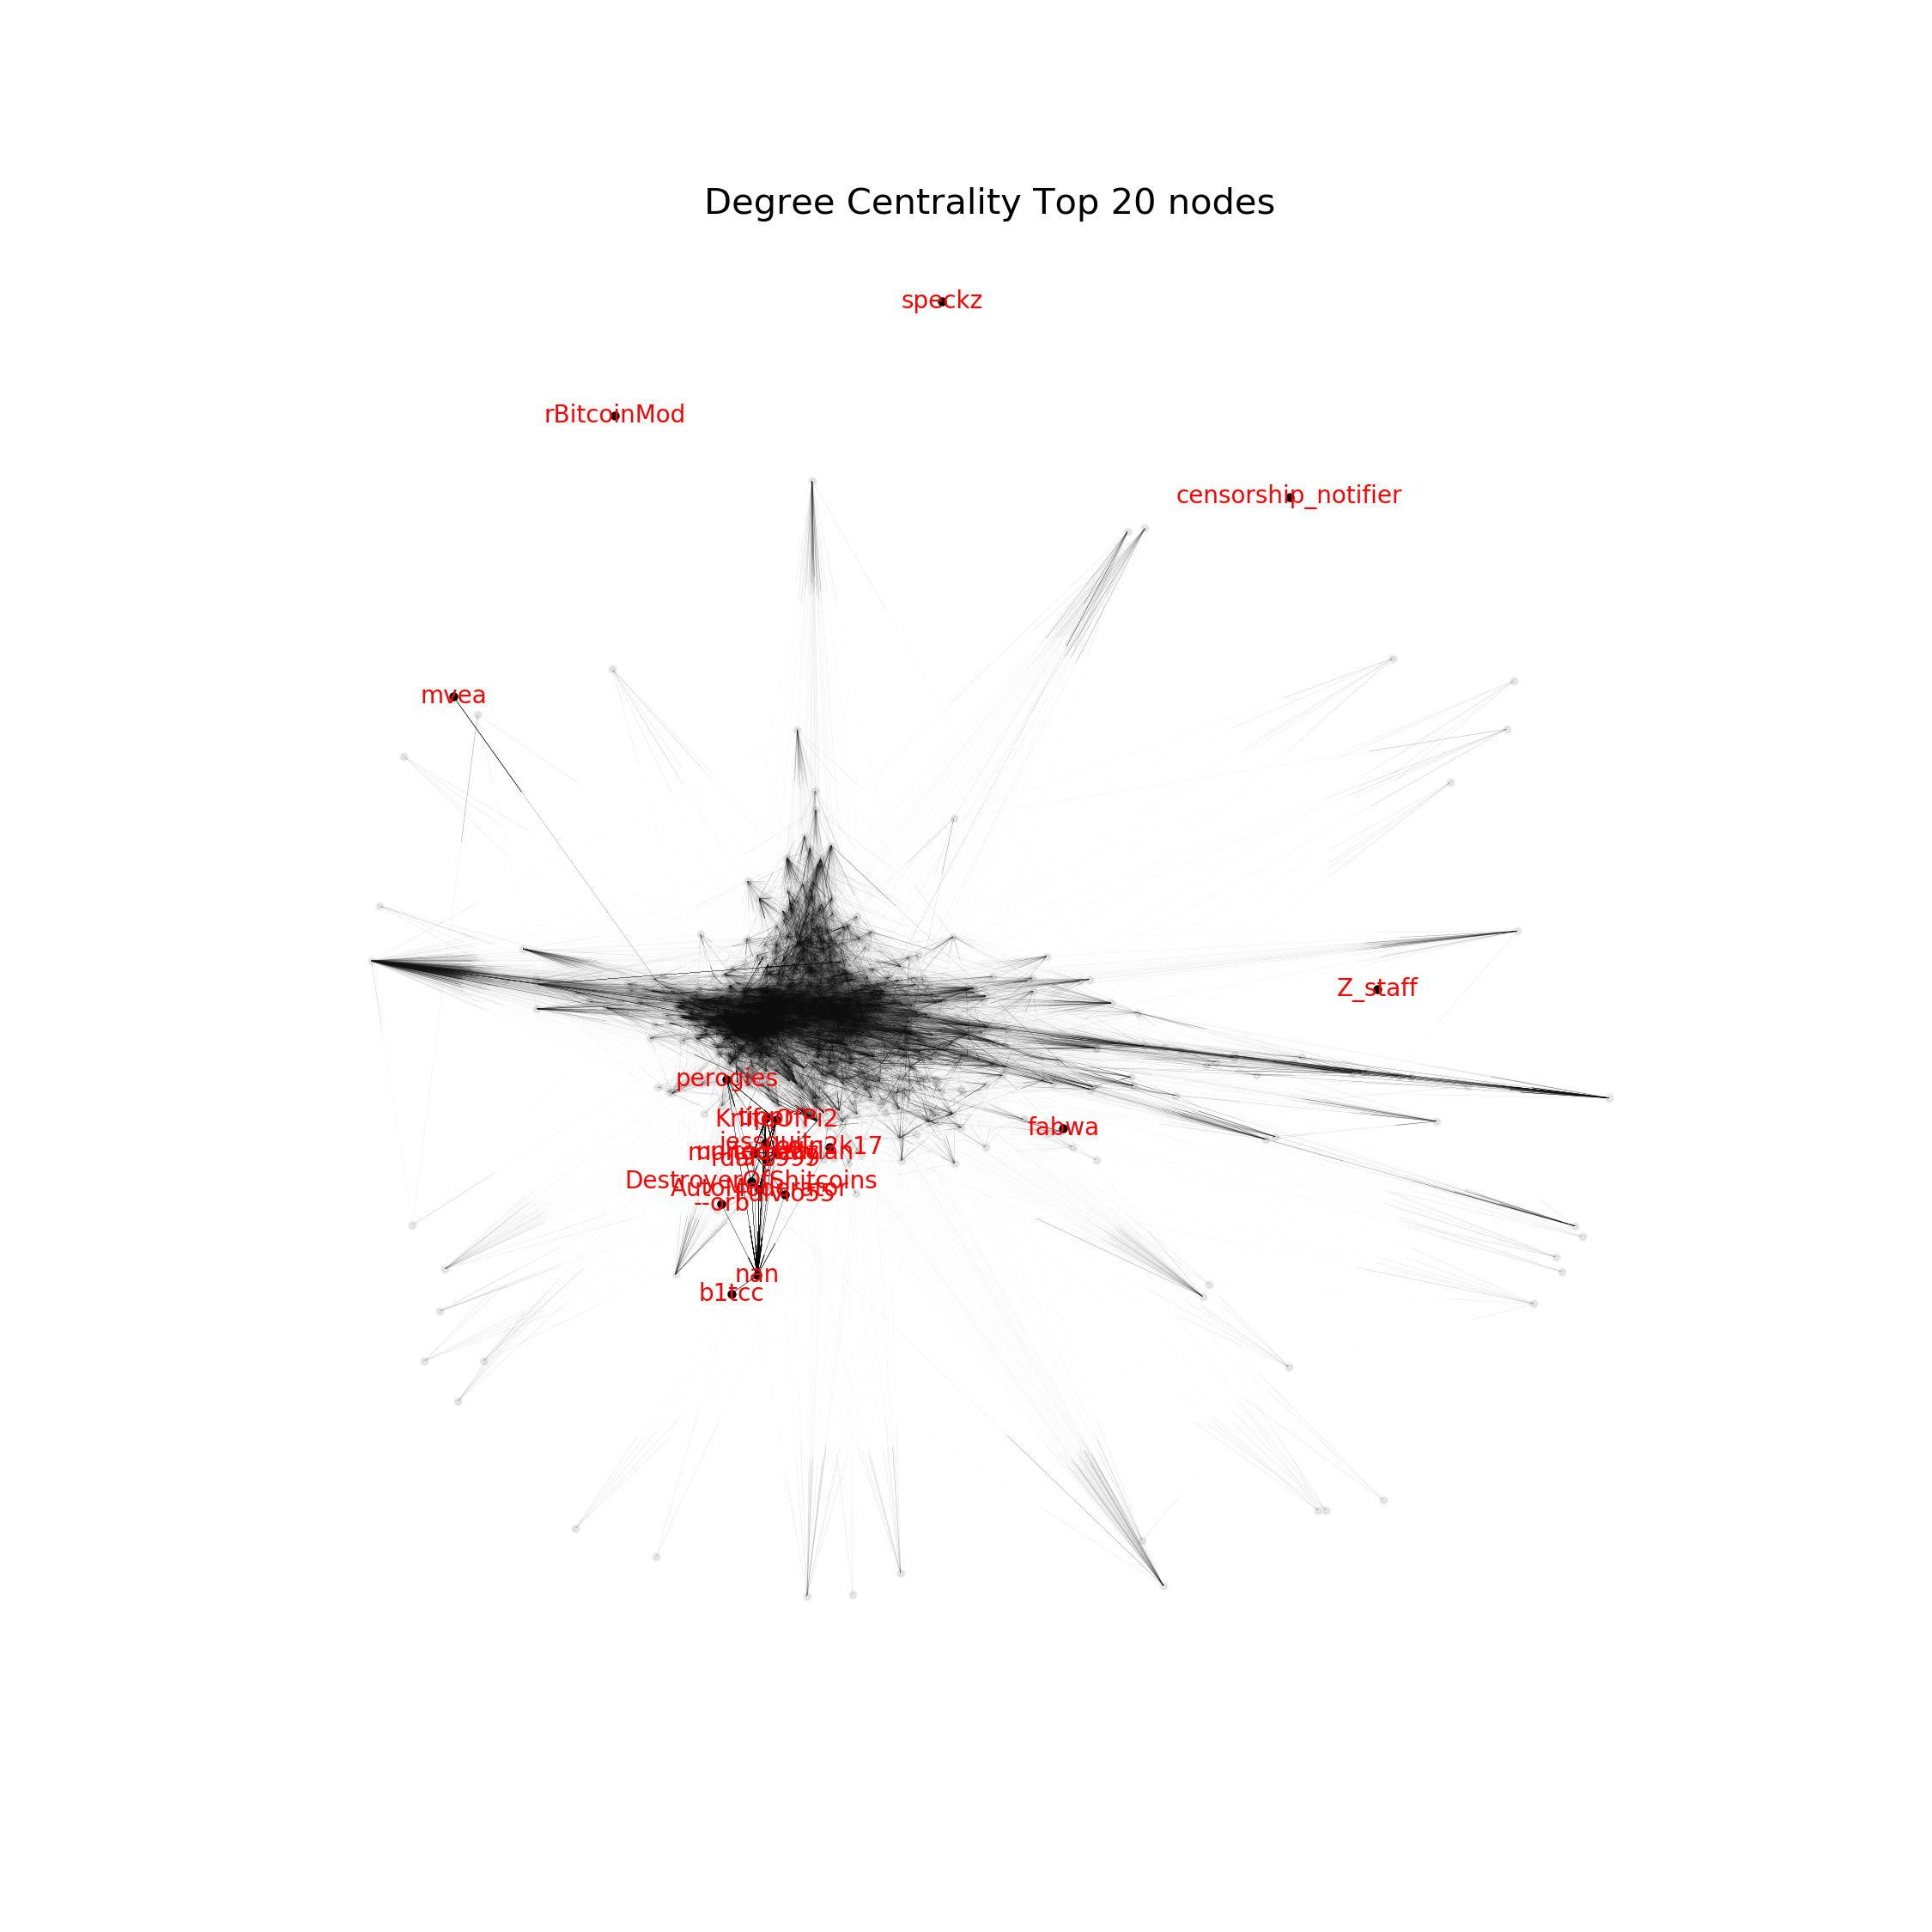

In [16]:
core1 = trim_top(g, deg_cen, n=1200)
core2 = trim_top(g, deg_cen, n=20)
draw_graph(core1, core2, 'Degree Centrality Top 20 nodes')

1200 20


<IPython.core.display.Javascript object>


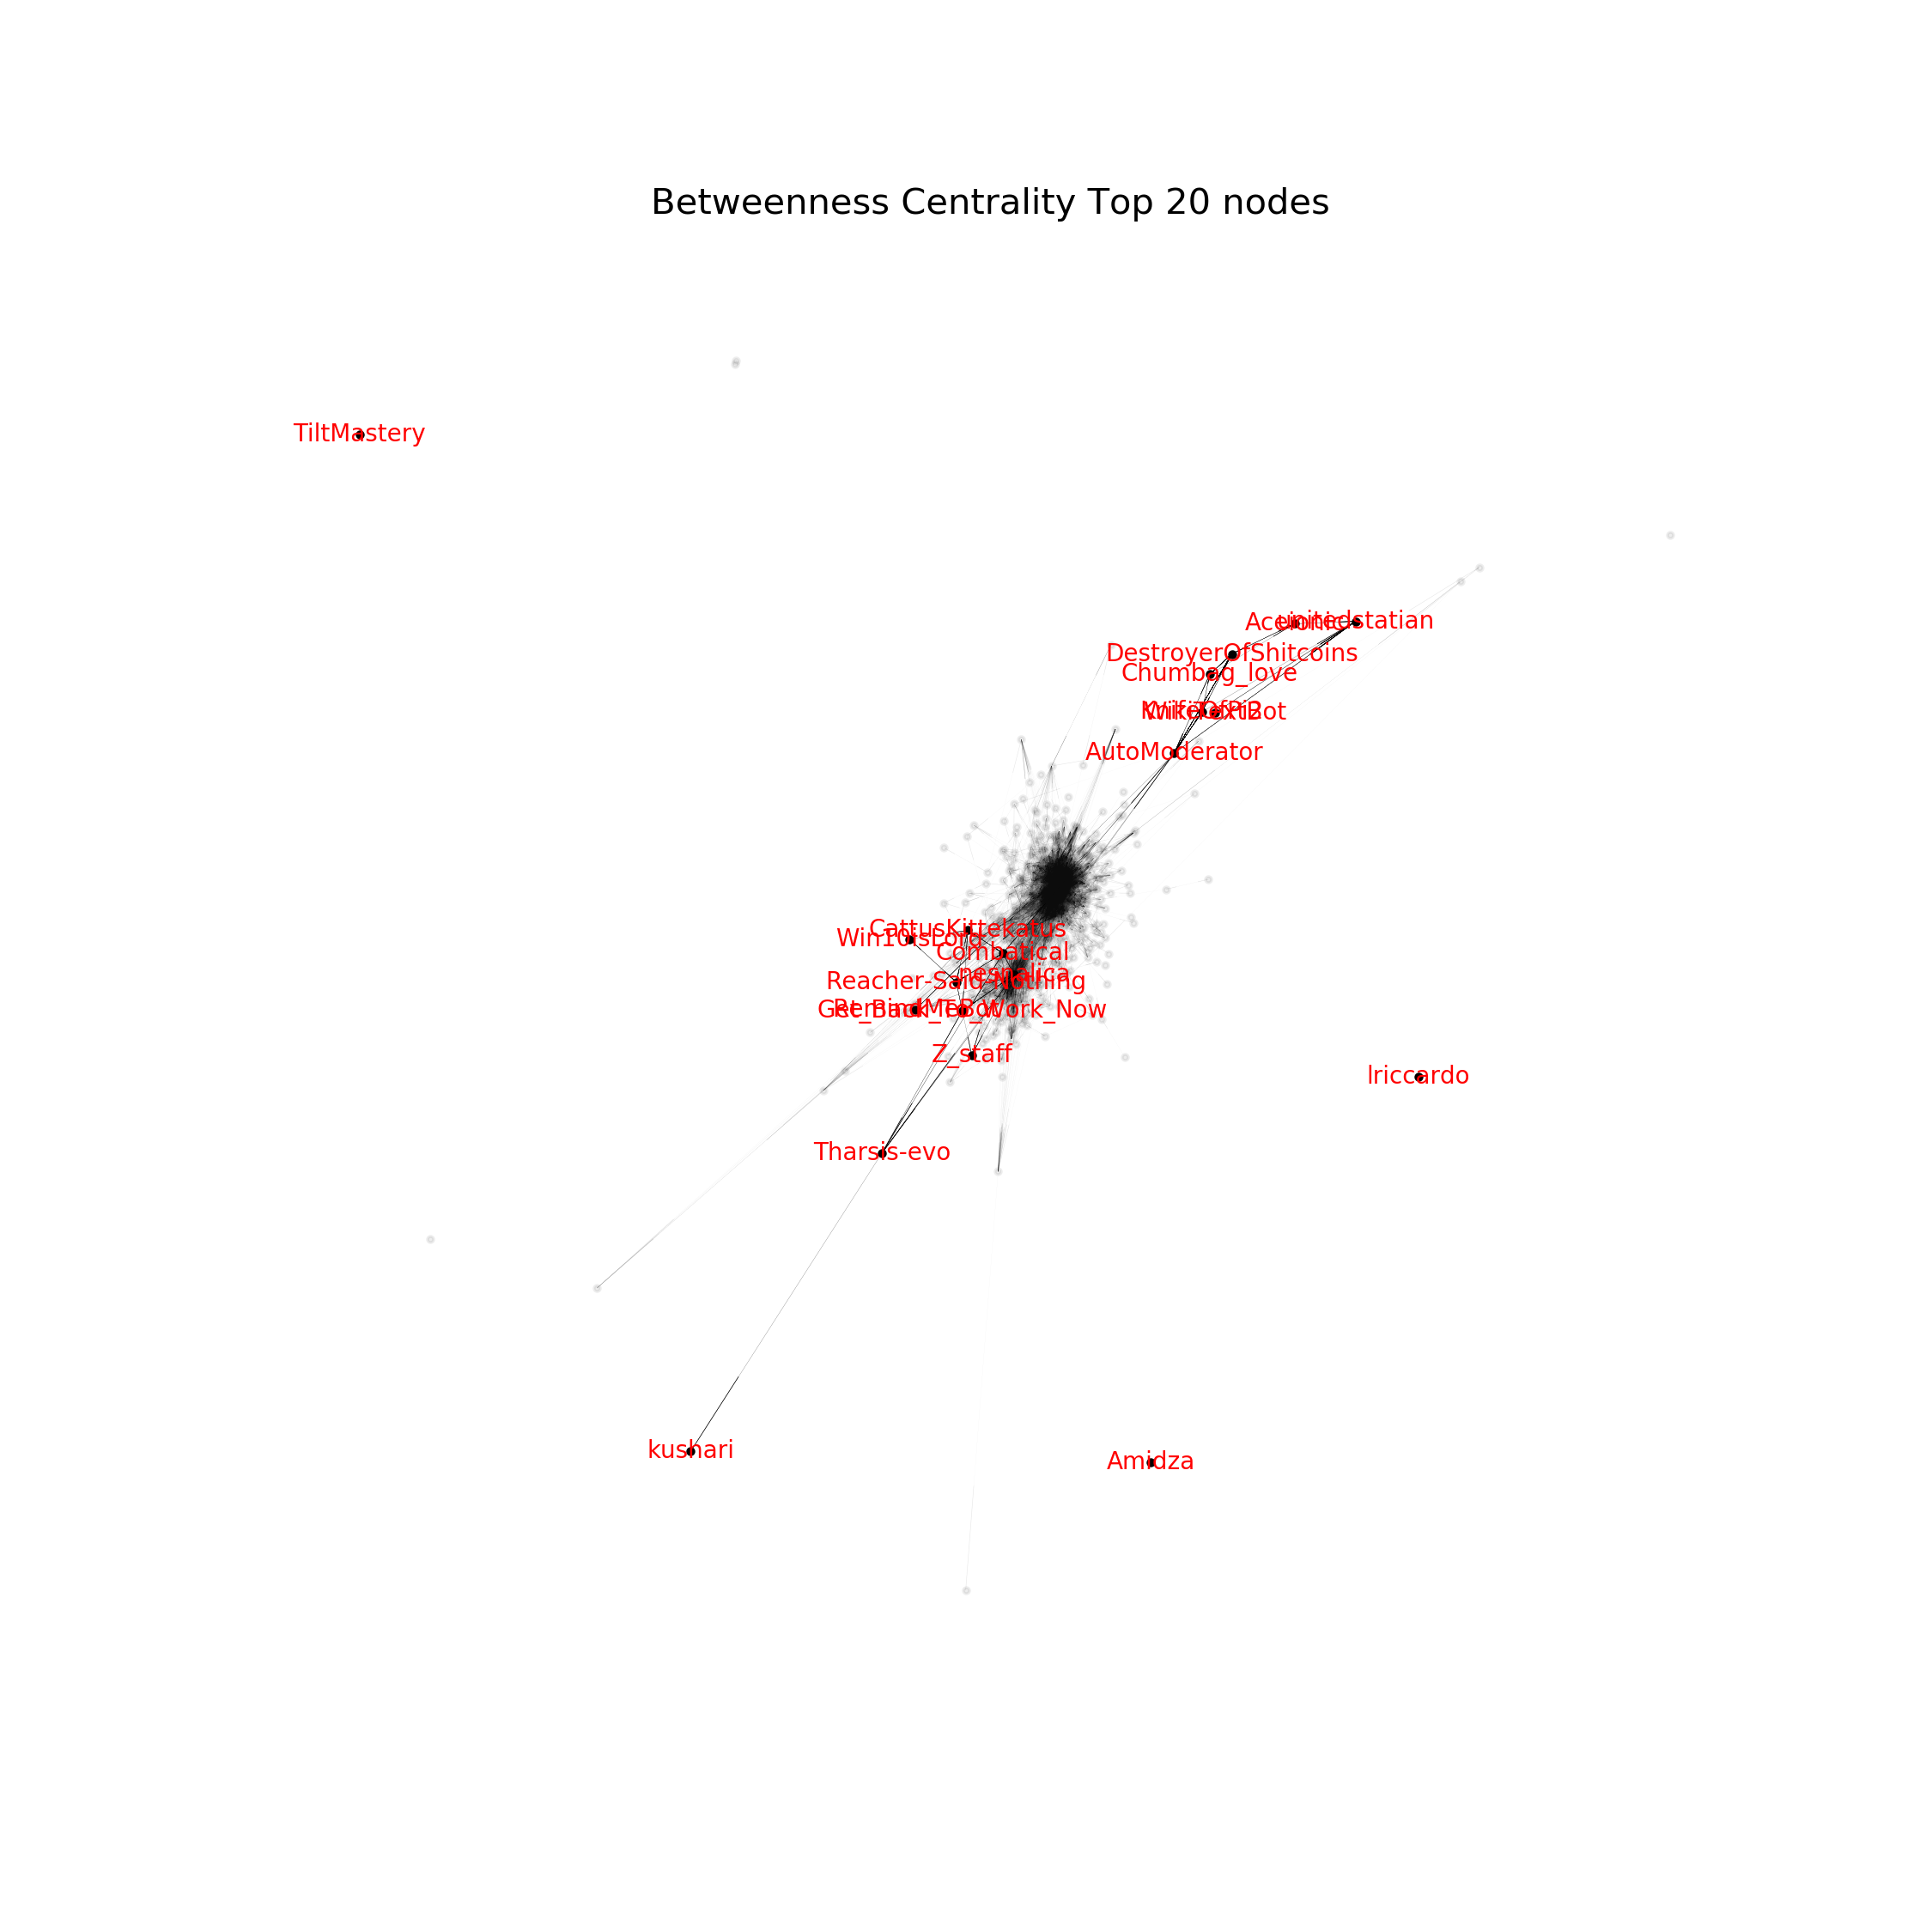

In [17]:
core1 = trim_top(g, betweenness_cen, n=1200)
core2 = trim_top(g, betweenness_cen, n=20)
draw_graph(core1, core2, 'Betweenness Centrality Top 20 nodes')

In [39]:
g_reduced = g.copy()
for n in g.nodes():
    if g.degree(n) <= 150:
        g_reduced.remove_node(n)

print(nx.info(g_reduced))

deg = sorted_df(nx.degree_centrality(g_reduced))
print(50*'-')
print(deg[0:top_num])

Name: 
Type: MultiDiGraph
Number of nodes: 3412
Number of edges: 202117
Average in degree:  59.2371
Average out degree:  59.2371
--------------------------------------------------
                       0         1
0                  tippr  1.232190
1                    NaN  1.184110
2          AutoModerator  1.139255
3             mungojelly  0.588684
4    censorship_notifier  0.559660
5               jessquit  0.453240
6                  b1tcc  0.425682
7               rdar1999  0.405746
8                  --orb  0.385224
9   DestroyerOfShitcoins  0.380827
10         unitedstatian  0.368514
11                 fabwa  0.349458
12              coin2k17  0.306655
13        btcnewsupdates  0.290237
14           rBitcoinMod  0.279683
15             Kain_niaK  0.277045
16            bambarasta  0.272647
17              perogies  0.269422
18            KnifeOfPi2  0.255057
19             LovelyDay  0.251539


In [37]:
bet = sorted_df(nx.betweenness_centrality(g_reduced, weight='weight', k=256))
print(50*'-')
print(bet[0:top_num])

--------------------------------------------------
                       0         1
0   DestroyerOfShitcoins  0.023226
1          AutoModerator  0.021934
2             mungojelly  0.016322
3               Aceionic  0.015612
4          unitedstatian  0.014806
5           Haramburglar  0.014077
6   2481632641282565121k  0.013303
7             BTCMONSTER  0.011916
8             KnifeOfPi2  0.010534
9               perogies  0.009701
10              rdar1999  0.009330
11               btcftw1  0.008711
12       throwawayTooFit  0.008623
13            arsonbunny  0.008246
14               audigex  0.008139
15              jessquit  0.008124
16    cryptomantothemoon  0.008065
17           i_gotta_say  0.007842
18                SAKUJ0  0.007789
19           Libertymark  0.007485


# Top 20 influencers by closeness centrality
### Koliko brzo data osoba može dopreti do svake druge osobe u mreži?

In [38]:
clo = sorted_df(nx.closeness_centrality(g_reduced))
print(50*'-')
print(clo[0:top_num])

--------------------------------------------------
                       0         1
0                    NaN  0.550844
1   DestroyerOfShitcoins  0.464048
2          unitedstatian  0.454522
3             arsonbunny  0.446173
4   2481632641282565121k  0.441872
5             KnifeOfPi2  0.441333
6                stevoli  0.441034
7             jonbristow  0.439545
8              normal_rc  0.438361
9             Vertigo722  0.434789
10   A_Internet_Stranger  0.432363
11              Aceionic  0.432191
12     UniqueUsername642  0.432019
13                SAKUJ0  0.426751
14                Wutanf  0.426583
15          Haramburglar  0.423806
16    PM_ME_UR_ROOM_VIEW  0.423751
17           TiltMastery  0.423035
18           cryptodirky  0.421337
19              ENSChamp  0.420575


1200 20


<IPython.core.display.Javascript object>


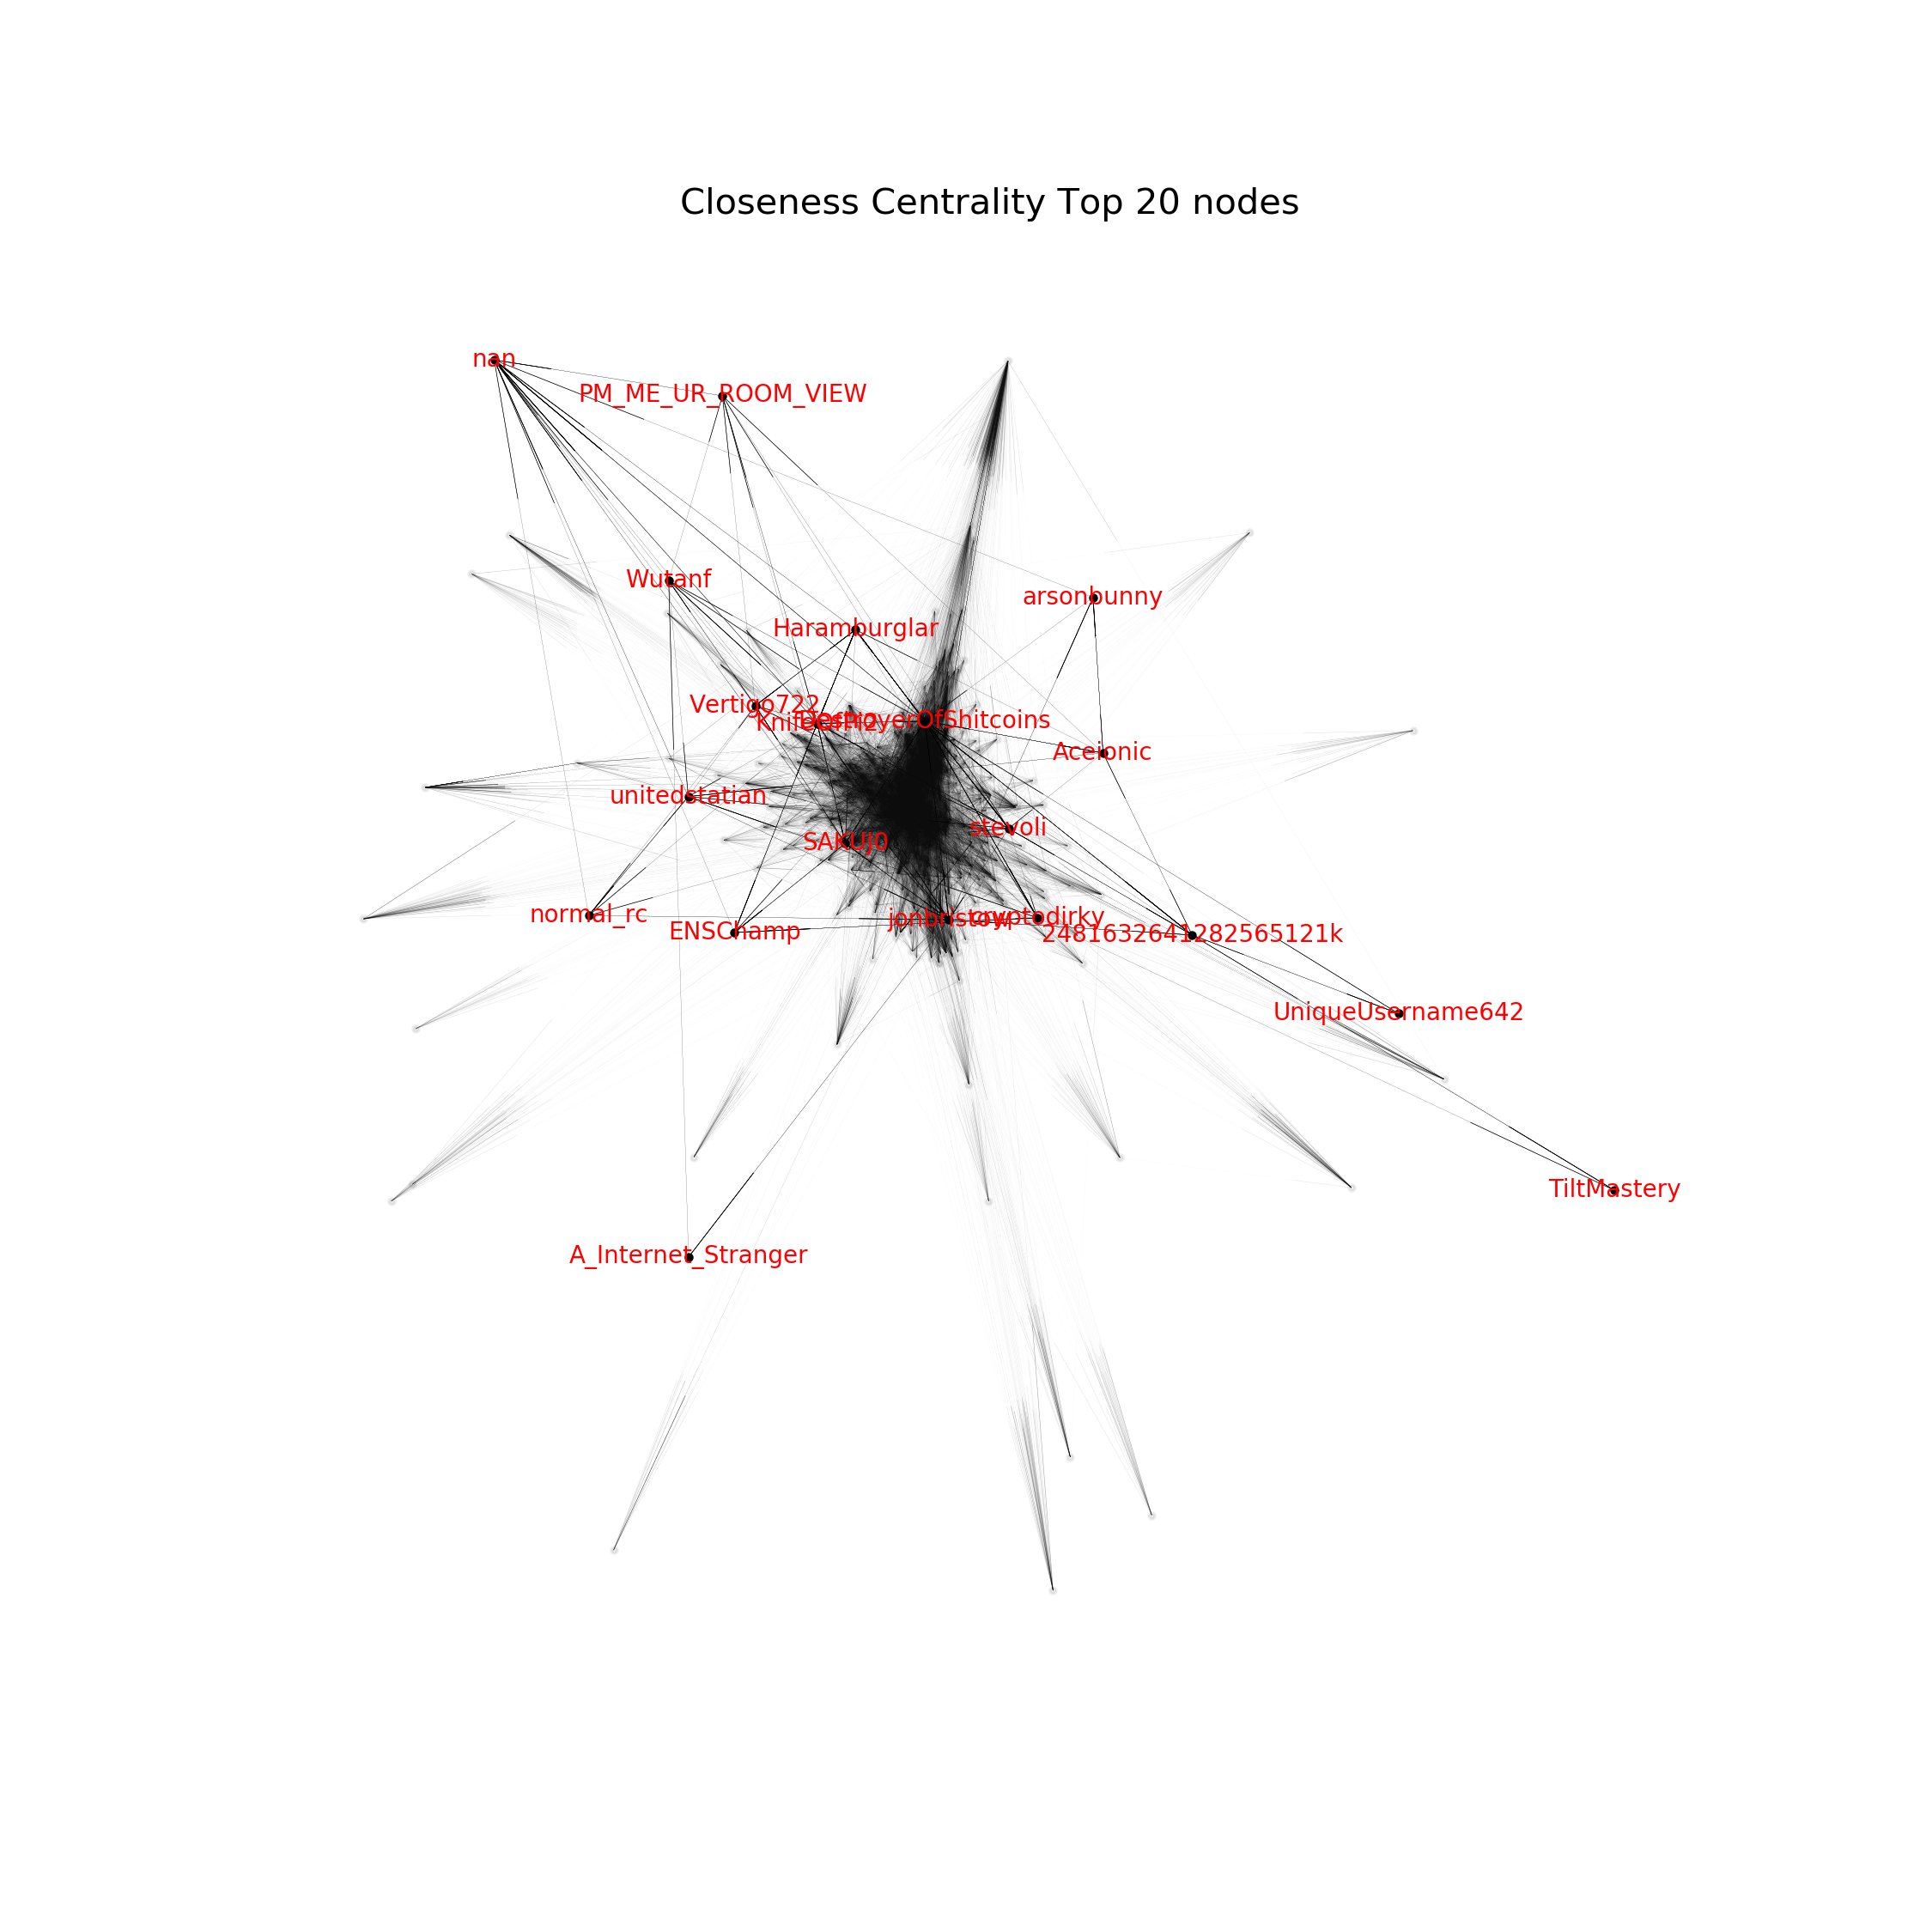

In [40]:
clo.to_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'closeness_150deg_trim.pkl')
bet.to_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'betweenness_150deg_trim.pkl')
core1 = trim_top(g_reduced, clo, n=1200)
core2 = trim_top(g_reduced, clo, n=20)
draw_graph(core1, core2, 'Closeness Centrality Top 20 nodes')

In [35]:
page_rank = sorted_df(nx.pagerank_scipy(g, alpha=0.8))
print(page_rank[0:top_num])

                  0         1
0              mvea  0.005083
1           Z_staff  0.004514
2       rBitcoinMod  0.001914
3            Amidza  0.001843
4               NaN  0.001731
5            speckz  0.001653
6             b1tcc  0.001477
7             fabwa  0.001289
8   HudsonRiverLine  0.000927
9        AdamCannon  0.000924
10   pixel-gamer-3D  0.000899
11   MichaelRahmani  0.000846
12        BluntLord  0.000833
13            tag65  0.000826
14      maxwellhill  0.000801
15    Gabriel-Lewis  0.000749
16     delumstudios  0.000747
17  Elementz_Reborn  0.000707
18        lriccardo  0.000665
19        iAmTheTot  0.000664
